# Compare My & ICP
- Einfache Situationen 
    - typischerweise median distance etwas über 3 mm
    - ICP hat dabei manchmal extreme Ausreisser
    - ansonsten mal das eine, mal das andere besser
    - bei Achszähler meist beide schlecht
    - Abweichung von mehreren cm: immer ICP schuld
- Schwierige Situationen: 
    - ICP versagt sehr oft, My manchmal

In [1]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree, cKDTree
from scipy.linalg import svd 
from osgeo import ogr
import pyvista as pv
import os
import csv
import time 
import matplotlib.pyplot as plt
import copy

import open3d as o3d
from interessant import * # Bei Änderungen Kernel neu starten


ogr.UseExceptions()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
tmpdir = "/media/riannek/minimax/gleis/temp_run24"

# Bahnsteig: 29; Gleis hohe Intensität: 11; Weiche B: 16; Unterirdischer Bhf: 20; Gleis weit abseits: 23; Betondeckel: 28; Zug run 14 A: 6; 
# Viele Gleise: 33; Anfang Weiche: 34; OLA gleiche H: 35; Y: 37; Auch viele Gleise: 43; Kreuzung: 44, 45;

key = list(interessant.keys())[0] #43

filename = interessant[key]
filename = filename.split(".")[0] + ".ply"
print(key, filename)


if not os.path.exists(os.path.join(tmpdir, "candidates", filename)):
    raise FileNotFoundError(filename)

# filename =  "4474100_5333625.ply"

Einfach 4473900_5335875.ply


In [3]:
thresh_side_distance = 0.15   # 0.1 ist meist gut, aber in manchen Fällen zu wenig (z.B. Anfang Weiche)

intensity_threshold = 14500
downsample_radius = 0.45 # 0.4
neighborhood_radius = 0.5 # 0.5

min_points = 10
minimum_in_hood = 10
linearity_tresh = 0.98

gauge = 1.435
railhead_width = 0.067

In [4]:
runfolder = "/media/riannek/minimax/gleis/run24-2024-08-13"

import subprocess
# subprocess.Popen(["pyvistaviewer", os.path.join(runfolder, filename.split(".")[0] + ".copc.laz")])

## Laden

In [5]:
gpkg = ogr.Open(os.path.join(tmpdir, "temp.gpkg"))
layer = gpkg.GetLayerByName("tiles")

In [6]:
def extend_bbox(bbox, margin=2):
    # MinX, MaxX, MinY, MaxY
    return (bbox[0] - margin, bbox[1] + margin, bbox[2] - margin, bbox[3] + margin)

def get_bbox_polygon(bbox):  
    ring = ogr.Geometry(ogr.wkbLinearRing)      
    ring.AddPoint_2D(bbox[0], bbox[2])  # MinX, MinY
    ring.AddPoint_2D(bbox[1], bbox[2])  # MaxX, MinY
    ring.AddPoint_2D(bbox[1], bbox[3])  # MaxX, MaxY
    ring.AddPoint_2D(bbox[0], bbox[3])  # MinX, MaxY
    ring.AddPoint_2D(bbox[0], bbox[2])  # Close ring
    geom = ogr.Geometry(ogr.wkbPolygon)
    geom.AddGeometry(ring)
    return geom

In [7]:
filter = f"filename = '{filename}'"
layer.SetAttributeFilter(filter)
feature = layer.GetNextFeature()
layer.SetAttributeFilter(None)
bbox = feature.GetGeometryRef().GetEnvelope()
extended = extend_bbox(bbox, margin=2)
bbox_geom = get_bbox_polygon(extended)
layer.SetSpatialFilter(bbox_geom)
tiles = [f.GetField("filename") for f in layer]
layer.SetSpatialFilter(None) 

print(tiles) 

['4473925_5335850.ply', '4473875_5335900.ply', '4473875_5335850.ply', '4473900_5335850.ply', '4473875_5335875.ply', '4473900_5335900.ply', '4473900_5335875.ply']


In [8]:
bbox # MinX, MaxX, MinY, MaxY

(4473900.0, 4473925.0, 5335875.0, 5335900.0)

In [9]:
del gpkg

In [10]:
bounds = f"([{extended[0]}, {extended[1]}], [{extended[2]}, {extended[3]}])" 
bounds

'([4473898.0, 4473927.0], [5335873.0, 5335902.0])'

In [11]:
readers = [pdal.Reader(os.path.join(tmpdir, "candidates", tile)) for tile in tiles]
pipeline = pdal.Pipeline(readers) | pdal.Filter.merge() | pdal.Filter.crop(bounds=bounds)
pipeline.execute()
points = pipeline.arrays[0]
points.shape 

(107650,)

In [12]:
low_intensity = points[points["Intensity"] < intensity_threshold]
low_intensity.shape

(57235,)

In [13]:
bounds = f"([{bbox[0]}, {bbox[1]}], [{bbox[2]}, {bbox[3]}])" 
bounds

'([4473900.0, 4473925.0], [5335875.0, 5335900.0])'

In [14]:
# Downsample with poisson sampling (only original bbox)

downsampling_pipeline = pdal.Filter.crop(bounds=bounds).pipeline(low_intensity) | pdal.Filter("filters.sample", radius=downsample_radius)
downsampling_pipeline.execute()
seed_points = downsampling_pipeline.arrays[0]
seed_point_count = seed_points.shape[0]
seed_point_count

266

In [15]:
xyz = np.vstack((points['X'], points['Y'], points['Z'])).transpose()
xyz_seed = np.vstack((seed_points['X'], seed_points['Y'], seed_points['Z'])).transpose()

In [16]:
offset = xyz.mean(axis=0).round() 
xyz -= offset
xyz_seed -= offset

In [17]:
tree = KDTree(xyz)  

# indices: ndarray (dtype object) with a list of indices for each seed point
indices = tree.query_ball_point(xyz_seed, r=neighborhood_radius, workers=-1)

In [18]:
def pca(cloud):
    """Use PCA to get einvalues and eigenvectors of a point cloud
    
    Returns (eigenvalues, eigenvectors)
    """
    if cloud.shape[0] < 3:
        raise ValueError("Point cloud must have at least 3 points")
    mean = np.mean(cloud, axis=0)
    centered = cloud - mean
    U, S, Vt = svd(centered, full_matrices=False)
    eigenvals = S**2/(cloud.shape[0]-1)
    # Returned vectors are in columns, first vector is eigenvec[:, 0] == eigenvec.T[0]
    return eigenvals, Vt.T


def linearity(eigenvals):
    """Calculate the linearity of a point cloud"""
    return (eigenvals[0] - eigenvals[1]) / eigenvals[0]


In [19]:
def dbscan_stretchz(xyz, min_points=10, stretch=1.5):

    pointcount = xyz.shape[0]
    if pointcount <= min_points:
        return np.ones(pointcount, dtype=np.int8) * -1
    
    eps = 50 / pointcount
    eps = max(eps, 0.06)
    
    xyz = xyz.copy()
    xyz[:, 2] *= stretch
    hood_pcd = o3d.geometry.PointCloud()
    hood_pcd.points = o3d.utility.Vector3dVector(xyz) 
    # eps is min distance between clusters
    labels = np.array(hood_pcd.cluster_dbscan(eps=eps, min_points=min_points, print_progress=False))
    return labels



In [20]:
def plot_first_eigenvec(point, eigenvects, color=[1, 0, 0], stretch=1):
    """Plot a vector as a line"""
    vector = eigenvects.T[0] * stretch
    end = point + vector
    line = o3d.geometry.LineSet()
    line.points = o3d.utility.Vector3dVector([point, end])
    line.lines = o3d.utility.Vector2iVector([[0, 1]])
    line.colors = o3d.utility.Vector3dVector([color])
    return line

In [21]:
def plot_cluster_line(cluster, eigenvects, stretch=0.2):
    start = cluster.mean(axis=0)
    vector = eigenvects.T[0] * stretch
    end = start + vector
    line = pv.Line(start, end)

    return line

In [22]:
def plot_cluster(cluster, eigenvects=None): 
    center = cluster.mean(axis=0)
    centered = cluster - center

    if eigenvects is None:
        eigenvals, eigenvects = pca(cluster)

    transformed = centered @ eigenvects
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax.set_aspect("equal")
    plt.show()
    return fig, ax

In [23]:
def to_color(skalar, cmap=plt.cm.plasma):
    return cmap(skalar)[:3]

In [24]:
def get_central_point(a, b):
    """Get the point in the middle of two points"""
    vector = b - a
    return a + vector / 2

In [25]:
def plot_cluster(cluster, eigenvects=None): 
    center = cluster.mean(axis=0)
    centered = cluster - center

    if eigenvects is None:
        eigenvals, eigenvects = pca(cluster)

    transformed = centered @ eigenvects
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax.set_aspect("equal")
    plt.show()
    return fig, ax
    

In [26]:
def cluster_is_on_top(cluster, clustercenter, points):
    """Check that there are no points above the cluster center"""
    x_min, x_max = clustercenter[0] - 0.05, clustercenter[0] + 0.05
    y_min, y_max = clustercenter[1] - 0.05, clustercenter[1] + 0.05
    z_min = cluster[:,2].max()

    mask = ((points[:, 0] > x_min) & 
        (points[:, 0] < x_max) & 
        (points[:, 1] > y_min) & 
        (points[:, 1] < y_max) & 
        (points[:, 2] > z_min))
    
    
    return points[mask].shape[0] == 0

In [27]:
def plot_cluster_pair(cluster, cluster_other, transformmatrix, percentile=95, railhead_width = 0.067, centering="cluster", point_this=None, point_other=None): 
    """Plot pair of clusters in the PCA coordinate system of the pair 
    
    Args:
        cluster (np.array): Cluster of points
        cluster_other (np.array): Other cluster of points
        eigenvects (np.array): Eigenvectors of the PCA of the pair of clusters
        percentile (int): Percentile of the height for the horizontal line
        railhead_width (float): Width of the railhead (0.067 or 0.072)
        centering (str): "cluster" or "pair"
    """
    center = (cluster.sum(axis=0) + cluster_other.sum(axis=0)) / (cluster.shape[0] + cluster_other.shape[0])
    center_cluster = cluster.mean(axis=0)
    center_other = cluster_other.mean(axis=0)

    if centering == "cluster":
        cluster = cluster - center_cluster
        cluster_other = cluster_other - center_other
        point_this = point_this - center_cluster
        point_other = point_other - center_other
    else:
        cluster = cluster - center
        cluster_other = cluster_other - center
        point_this = point_this - center
        point_other = point_other - center

    transformed = cluster @ transformmatrix
    transformed_other = cluster_other @ transformmatrix
    #print("center", center)
    #print(center_cluster - center, center_other - center)
    #print((center_cluster - center) @ transformmatrix, (center_other - center) @ transformmatrix)


    # Check if we need to switch the left, right cluster
    center_cluster_in_pc = (center_cluster - center) @ transformmatrix
    center_other_in_pc = (center_other - center) @ transformmatrix
    if center_cluster_in_pc[0] > center_other_in_pc[0]:
        transformed, transformed_other = transformed_other, transformed
        point_this, point_other = point_other, point_this
        # print("Switched clusters")

    fig, ax = plt.subplots(1,2, figsize=(15, 7))

    if centering == "cluster":
        ax[0].set_ylim(-0.08, 0.06)
        ax[1].set_ylim(-0.08, 0.06)
    else:
        ax[0].set_xlim(-0.85, -0.65)
        ax[0].set_ylim(-0.08, 0.06)
        ax[1].set_xlim(0.65, 0.85)
        ax[1].set_ylim(-0.08, 0.06)
        ax[0].axvline(-gauge/2, color="lightgrey", linestyle="-", zorder=-1)
        ax[0].axvline(-gauge/2 - railhead_width, color="lightgrey", linestyle="-", zorder=-1)
        ax[1].axvline(gauge/2, color="lightgrey", linestyle="-", zorder=-1)
        ax[1].axvline(gauge/2 + railhead_width, color="lightgrey", linestyle="-", zorder=-1)

    ax[0].scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax[0].set_aspect("equal")

    x_mean = transformed[:,0].mean()
    ax[0].axvline(x_mean, color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axvline(x_mean - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axvline(x_mean + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axhline(np.percentile(transformed[:,2], percentile), color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axhline(transformed[:,2].mean(), color="forestgreen", linestyle="--", zorder=-1)

    ax[1].scatter(transformed_other[:,0], transformed_other[:,2], c=transformed_other[:,1], cmap=plt.cm.plasma, marker=".")
    ax[1].set_aspect("equal")

    x_mean = transformed_other[:,0].mean()
    ax[1].axvline(x_mean, color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axvline(x_mean - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axvline(x_mean + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axhline(np.percentile(transformed_other[:,2], percentile), color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axhline(transformed_other[:,2].mean(), color="forestgreen", linestyle="--", zorder=-1)

    if point_this is not None:
        point_this_transformed = point_this  @ transformmatrix
        ax[0].axvline(point_this_transformed[0], color="red", linestyle="--", zorder=-1)
        ax[0].axhline(point_this_transformed[2], color="red", linestyle="--", zorder=-1)
        ax[0].axvline(point_this_transformed[0] - (railhead_width/2), color="tomato", linestyle="--", zorder=-1)
        ax[0].axvline(point_this_transformed[0] + (railhead_width/2), color="tomato", linestyle="--", zorder=-1)
        ax[0].annotate(f"{point_this_transformed[0]:.5f}", xy=(point_this_transformed[0], point_this_transformed[2]), xytext=(point_this_transformed[0] + 0.01, point_this_transformed[2] + 0.01), fontsize=10, color="red", ha="left", va="bottom")

    if point_other is not None:
        point_other_transformed = point_other  @ transformmatrix
        ax[1].axvline(point_other_transformed[0], color="red", linestyle="--", zorder=-1)
        ax[1].axhline(point_other_transformed[2], color="red", linestyle="--", zorder=-1)
        ax[1].axvline(point_other_transformed[0] - (railhead_width/2), color="tomato", linestyle="--", zorder=-1)
        ax[1].axvline(point_other_transformed[0] + (railhead_width/2), color="tomato", linestyle="--", zorder=-1)
        ax[1].annotate(f"{point_other_transformed[0]:.5f}", xy=(point_other_transformed[0], point_other_transformed[2]), xytext=(point_other_transformed[0] + 0.01, point_other_transformed[2] + 0.01), fontsize=10, color="red", ha="left", va="bottom")

    plt.show()
    return fig, ax, transformed, transformed_other




In [28]:
def which_side(cluster):
    """Check which on which side of the rail the transformed cluster is
    
    Returns a value between -1 and 1, positive values if points are on the 
    right side of the rail, and negative values for the left side. 
    The absolute value is kind of the confidence of the estimation.
    """

    # Count the points below the centroid, on the left and the right side 
    # but only within half the width of the railhead 

    left_mask = (cluster[:,2] < 0) & (cluster[:,0] < 0) & (cluster[:,0] > -railhead_width/2)
    right_mask = (cluster[:,2] < 0) & (cluster[:,0] > 0) & (cluster[:,0] < railhead_width/2)
    left_count = np.sum(left_mask)
    right_count = np.sum(right_mask)
    both_count = left_count + right_count
    if both_count == 0:
        return 0
    return (left_count - right_count) / both_count

In [29]:

def representive_point(cluster, transformmatrix, upperpercentile=90, lowerpercentile=70, railhead_width=0.067, side=None):
    """Version 3s

    Unterschied bei "Vor allem Top": 
        min und max x bei z>-0.01
        lowerpercentile des oberen Teils für z
    """


    center = cluster.mean(axis=0)
    centered = cluster - center
    transformed = centered @ transformmatrix

    max_z = transformed[:,2].max()

    if max_z < 0.03:
        # This happens if most points are on the top of the rail (usually max_z close to 0.02)
        # Calculate the mean of the range for points above -0.01
        # (this makes sure we get the approx. railhead width)
        transformed_x_upper = transformed[transformed[:,2] > -0.01][:,0]
        center_x = (transformed_x_upper.max() + transformed_x_upper.min()) / 2
        # only consider points above the centroid
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], lowerpercentile)
        side = 0
    else:
        # Many points are on the side of the rail (usually the max_z around 0.04)
        # but we need check which side 

        if side is None:
            side = which_side(transformed)

        # x values of points above the centroid
        # (there might be outliers in the lower part of the cluster)
        transformed_x_upper = transformed[transformed[:,2] > 0][:,0]

        if side < 0:
            # left side
            # Only consider one quadrant in the transformed space
            # This makes clusters with more or less points on the rail top more comparable
            # IndexError if the cluster is shifted from the ideal position due to extrem outliers
            # (happens in rare cases at switches)
            try:
                min_x = np.percentile(transformed_x_upper[transformed_x_upper < 0],100-lowerpercentile)
            except IndexError:
                return None, None
            center_x = min_x + railhead_width / 2
        else:
            try:
                max_x = np.percentile(transformed_x_upper[transformed_x_upper > 0],lowerpercentile)
            except IndexError:
                return None, None
            center_x = max_x - railhead_width / 2 
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], upperpercentile)

    
    transformed_representive = np.array([center_x, 0, center_z])

    return transformed_representive @ transformmatrix.T + center, side

In [30]:
def get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects):
    # Use the top part of the rail clusters to circumvent the problem different point distributions
    top = cluster[:,2].max()
    top_other = cluster_other[:,2].max()
    topcenter = np.array([clustercenter[0], clustercenter[1], top])
    topcenter_other = np.array([clustercenter_other[0], clustercenter_other[1], top_other])
    sidevector = topcenter - topcenter_other
    # Project on the plane perpendicular to the first eigenvector
    # (eigenvects are normalized)
    projection_on_first_eig = (sidevector @ eigenvects.T[0]) * eigenvects.T[0]
    sidevector_perpendicular = sidevector - projection_on_first_eig
    sidevector_perpendicular = sidevector_perpendicular / np.linalg.norm(sidevector_perpendicular)
    normal = np.cross(sidevector_perpendicular, eigenvects.T[0]) 

    matrix = np.array([sidevector_perpendicular, eigenvects.T[0], normal]).T

    if normal[2] < 0:
        Rx_180 = np.array([
            [1,  0,  0],
            [0, -1,  0],
            [0,  0, -1]
        ])
        # Data in row vector, this is first the main rotation, than the rotation around the y axis
        matrix = matrix @ Rx_180 

    return matrix

In [31]:
def draw_registration_result(source, target, transformation):
    axes = axes = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.1)
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp, axes])


In [32]:
def load_clusters(preset):
    fileleft = f"clusterbeispiele/{preset}_l.ply"
    fileright = f"clusterbeispiele/{preset}_r.ply"
    filepair = f"clusterbeispiele/{preset}_pair.ply"
    if not os.path.exists(fileleft):
        raise FileNotFoundError(f"File {fileleft} not found")
    cluster = o3d.io.read_point_cloud(fileleft)
    cluster_other = o3d.io.read_point_cloud(fileright)
    cluster_pair = o3d.io.read_point_cloud(filepair)
    return np.asarray(cluster.points) , np.asarray(cluster_other.points), np.asarray(cluster_pair.points)

In [33]:
def cluster_generator(points, min_points):
    if points.shape[0] < min_points:
        return
    
    labels = dbscan_stretchz(points, min_points=min_points, stretch=4)

    # if len(labels) == 0:
    #     return
    
    max_label = labels.max()
    
    for label in range(max_label + 1):
        cluster = points[labels == label]
        if cluster.shape[0] < min_points:
            # Somehow this happens, must be a bug in open3d
            continue

        eigenvals, eigenvects = pca(cluster)
        cluster_linearity = linearity(eigenvals)


        if not ((cluster_linearity > linearity_tresh) and (eigenvals[0] > 0.04)):
            # Cluster not linear or too short
            continue

        clustercenter = cluster.mean(axis=0)

        # Make sure there are no points above the cluster
        # (exclude clusters at the base of the track profile)
        if not cluster_is_on_top(cluster, clustercenter, points):
            continue
        
        # Make sure there are no points above the cluster
        # (exclude clusters at the base of the track profile)
        if not cluster_is_on_top(cluster, clustercenter, points):
            continue

        # Make sure to include all points in lower part that might be chopped 
        # off by DBSCAN

        # Calculate distance from vertical plane along rail direction
        plane_normal = np.cross(eigenvects[:,0], np.array([0, 0, 1]))
        plane_normal /= np.linalg.norm(plane_normal)
        vects = points - clustercenter
        distances = np.abs(vects @ plane_normal)
        # And include points closer than 0.02 that are not yet part of the cluster
        mask = (distances < 0.02) & (labels != label)
        cluster = np.vstack((cluster, points[mask]))
        clustercenter = cluster.mean(axis=0)

        yield cluster, clustercenter, eigenvals, eigenvects


def check_cluster_for_railpair(clustercenter, eigenvects, pointcloud, tree, gauge, min_points):

    # Check for rail pair
    sidevector = np.cross(eigenvects[:,0], np.array([0, 0, 1])) * (gauge + 0.07) # Add railtop width to gauge
    bothsides = np.array([clustercenter + sidevector, clustercenter - sidevector])

    indices_bothsides = tree.query_ball_point(bothsides, r=neighborhood_radius)
    
    # Linear cluster that is closest to one of the estimated side points (ignoring z)
    # but must me within r = 15 cm and almost parallel

    closest_cluster_distance = np.inf
    closest_cluster = None
    closest_cluster_center = None
    
    for j, side in enumerate(indices_bothsides):
        for sidecluster, sideclustercenter, _, eigenvects_side in cluster_generator(pointcloud[side], min_points):
            
            # Check distance
            sidecluster_distance = np.linalg.norm(sideclustercenter[:2] - bothsides[j][:2]) # only xy
            if sidecluster_distance < thresh_side_distance and sidecluster_distance < closest_cluster_distance:
                # Check if parallel
                cos_angle = np.abs(np.dot(eigenvects[:,0], eigenvects_side[:,0]))
                if cos_angle > 0.9:  
                    closest_cluster = sidecluster
                    closest_cluster_distance = sidecluster_distance
                    closest_cluster_center = sideclustercenter

    return closest_cluster, closest_cluster_center

In [34]:
def pair_generator():

    for i in range(seed_point_count):
        for cluster, clustercenter, eigenvals, eigenvects in cluster_generator(xyz[indices[i]], min_points=min_points):
            cluster_other, center_other = check_cluster_for_railpair(clustercenter, eigenvects, xyz, tree, gauge, min_points)
            if cluster_other is not None:
                yield cluster, clustercenter, cluster_other, center_other, eigenvects 

In [35]:
def get_o3d_transform(eigenvects, translation=None):
    """Create an open3d 4x4 transformation matrix from eigenvectors
    
    Version für 2 Schienen
    """
    eigenvects = eigenvects.copy()

    # Check if the last eigenvector is pointing down
    if eigenvects[2,2] < 0: # z of last eigenvector is negative
        # print("o3d trans was Upside down")
        # reflect
        eigenvects[:,2] *= -1 # reflection 

    # There is a 50% chance that det(eigenvects) is close to -1
    # (then the matrix includes a reflection)
    if np.linalg.det(eigenvects) < 0:
        # flip the first eigenvector
        eigenvects[:,0] *= -1


    transform = np.eye(4)
    transform[0:3, 0:3] = eigenvects

    if translation is not None:
        transform[:3, 3] = translation
    return transform

In [36]:
templatefiles = [
    "T_profil_ähnlich_54E4.ply", 
    "T_profil_ähnlich_54E4_schräg_random2.ply",
    "T_profil_ähnlich_54E4_schräg_random_wenig_punkte.ply"
    ]

In [37]:
def get_template(filename):
    shift = (gauge + railhead_width) / 2
    pcd = o3d.io.read_point_cloud(os.path.join("templates", filename))
    left = np.asarray(pcd.points)
    right = left.copy()
    left[:,0] -= shift
    right[:,0] += shift

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.vstack((left, right)))
    return pcd

In [38]:
translations = [None, np.array([0, 0, 0.03])]
translation = translations[1]

In [39]:
templatenr = 1
templatefile = templatefiles[templatenr]
source = get_template(templatefile)

lines = []
mypoints = []
icppoints = []
pre_centers = []
distances = []
side = []



for cluster_this, clustercenter, cluster_other, center_other, eigenvects in pair_generator():
    cluster_pair = np.vstack((cluster_this, cluster_other))

    # My version
    _, eigenvects = pca(cluster_this)
    plottransform = get_transformmatrix(cluster_this, cluster_other, cluster_this.mean(axis=0), cluster_other.mean(axis=0), eigenvects)

    point_this, side_a = representive_point(cluster_this, plottransform)
    point_other, side_b = representive_point(cluster_other, plottransform)

    if point_this is None or point_other is None:
        # Happens in rare cases at switches
        continue

    if side_a * side_b < 0:
        # Update the cluster with lower confidence of the side estimation
        if np.abs(side_a) < np.abs(side_b):
            point_this, side_a  = representive_point(cluster_this, plottransform, railhead_width=0.067, side=side_b)
        else:
            point_other, side_b = representive_point(cluster_other, plottransform,  railhead_width=0.067, side=side_a)

    if point_this is None or point_other is None:
        continue

    my_centralpoint = get_central_point(point_this, point_other)


    # ICP
    source = get_template(templatefile)
    _, eigenvects_pair = pca(cluster_pair)
    center = get_central_point(cluster_this.mean(axis=0), cluster_other.mean(axis=0))
    pre_centers.append(center)
    centered = cluster_pair - center
    centered_pcd = o3d.geometry.PointCloud()
    centered_pcd.points = o3d.utility.Vector3dVector(centered)
    trans_init = get_o3d_transform(eigenvects_pair, translation)
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, centered_pcd, 0.02, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())

    icp_centralpoint = center + reg_p2p.transformation[:3, 3]  
    distance = np.linalg.norm(my_centralpoint - icp_centralpoint)
    distances.append(distance)
    side.append(side_a)
    lines.append(pv.Line(my_centralpoint, icp_centralpoint))
    mypoints.append(my_centralpoint)
    icppoints.append(icp_centralpoint)



In [40]:
distances = np.array(distances)

print("Mean", distances.mean())
print("Median", np.median(distances))
# print("Q1", np.percentile(distances, 25))
# print("Q3", np.percentile(distances, 75))
print("Max", distances.max())
# print("Min", distances.min())
print("Std", distances.std())
print("Num", distances.shape[0])

print()
print("Nur < 1 cm")
distances_small = distances[distances < 0.01]
print("Mean", distances_small.mean())
print("Median", np.median(distances_small))
# print("Q1", np.percentile(distances_small, 25))
# print("Q3", np.percentile(distances_small, 75))
# print("Max", distances_small.max())
# print("Min", distances_small.min())
print("Std", distances_small.std())
print("num", distances_small.shape[0])

print()
print("Nur 0--0.003 cm")
distances_small1 = distances[(distances < 0.003) ]
print("Mean", distances_small1.mean())
# print("Median", np.median(distances_small))
print("Std", distances_small1.std())
print("num", distances_small1.shape[0])

print()
print("Nur 0.003--0.01 cm")
distances_small1 = distances[(distances >= 0.003) & (distances < 0.01) ]
print("Mean", distances_small1.mean())
# print("Median", np.median(distances_small))
print("Std", distances_small1.std())
print("num", distances_small1.shape[0])





Mean 0.0033495551477108546
Median 0.003770286297936098
Max 0.007162847710280303
Std 0.0015913426739360835
Num 175

Nur < 1 cm
Mean 0.0033495551477108546
Median 0.003770286297936098
Std 0.0015913426739360835
num 175

Nur 0--0.003 cm
Mean 0.0015629348121495887
Std 0.000601892669974739
num 66

Nur 0.003--0.01 cm
Mean 0.004431361956399329
Std 0.0008621432649953537
num 109


In [41]:
import pandas as pd 
df = pd.DataFrame({
    "Distanz": distances,
    "side": side,
})
df.head()

,Distanz,side
0,0.001588,0.0
1,0.001087,0.0
2,0.002203,0.0
3,0.007150,0.0
4,0.005119,0.0


In [42]:
df["Gleis"] = "Parallelgleis"
df.loc[df["side"] == 0, "Gleis"] = "Befahren"

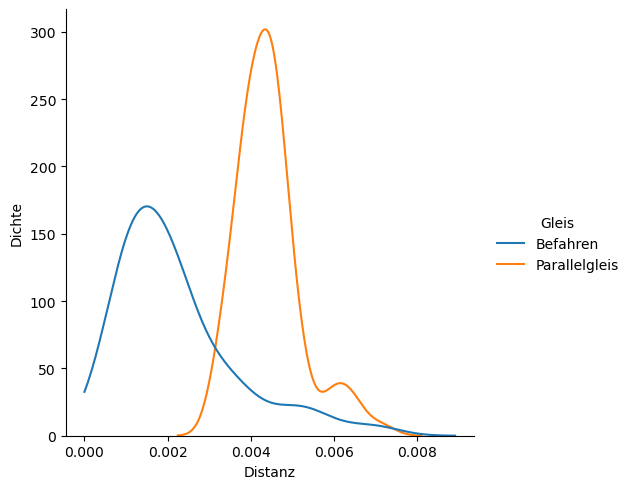

In [43]:
import seaborn as sns

g = sns.displot(data=df, x="Distanz", hue="Gleis", kind="kde",clip=(0, None))
g.set_axis_labels(x_var="Distanz", y_var="Dichte")

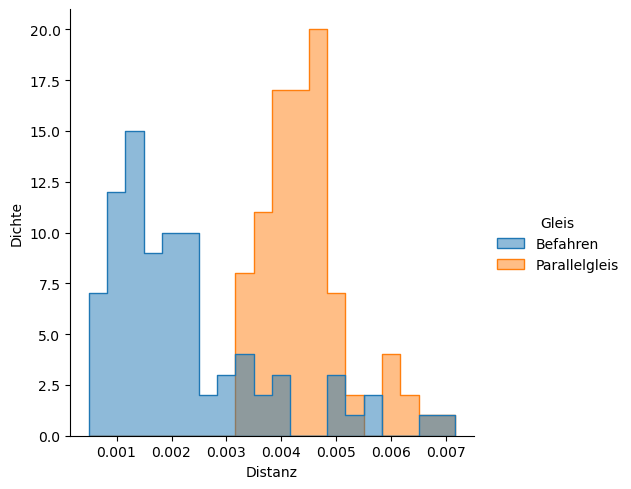

In [44]:
g = sns.displot(data=df, x="Distanz", hue="Gleis", bins=20, alpha=0.5, element="step")
g.set_axis_labels(x_var="Distanz", y_var="Dichte")

In [45]:
df[df["Gleis"] == "Parallelgleis"].describe()

,Distanz,side
count,90.000000,90.000000
mean,0.004434,-0.050577
std,0.000775,0.794376
min,0.003192,-0.905882
25%,0.003925,-0.811111
50%,0.004378,-0.748563
75%,0.004678,0.770849
max,0.007163,0.911602


In [46]:
df[df["Gleis"] == "Befahren"].describe()

,Distanz,side
count,85.000000,85.0
mean,0.002202,0.0
std,0.001431,0.0
min,0.000492,0.0
25%,0.001191,0.0
50%,0.001817,0.0
75%,0.002583,0.0
max,0.007150,0.0


In [47]:
fig = g.figure 
fig.savefig( "distances_einfach.png", dpi=300)

Text(0.5, 1.0, 'Distances < 1 cm')

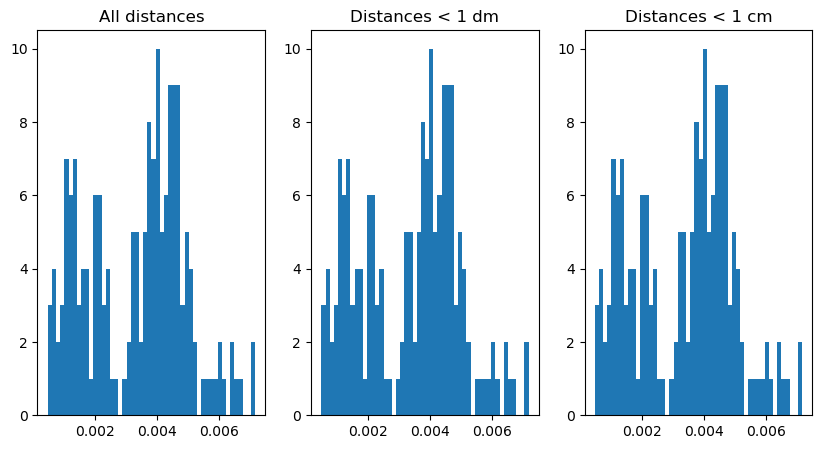

In [48]:

fig, ax = plt.subplots(1,3, figsize=(10, 5))
ax[0].hist(distances, bins=50)
ax[0].set_title("All distances")
ax[1].hist(distances[distances < 0.1], bins=50)
ax[1].set_title("Distances < 1 dm")
ax[2].hist(distances[distances < 0.01], bins=50)
ax[2].set_title("Distances < 1 cm")

In [49]:
distances_z = np.array(distances_z)
print("Mean z", distances_z.mean())
print("Median z", np.median(distances_z))
print("Max z", distances_z.max())
print("Min z", distances_z.min())
print("Std z", distances_z.std())

NameError: name 'distances_z' is not defined

In [ ]:
distances_xy = np.array(distances_xy)
print("Mean xy", distances_xy.mean())
print("Median xy", np.median(distances_xy))
print("Max xy", distances_xy.max())
print("Min xy", distances_xy.min())
print("Std xy", distances_xy.std())


Mean xy 0.0032185020284837096
Median xy 0.0036674335319001913
Max xy 0.007152752156133295
Min xy 7.778689354721356e-05
Std xy 0.0015694870038952323


In [ ]:
mypoints = np.array(mypoints)
icppoints = np.array(icppoints)
pre_centers = np.array(pre_centers)

pcd_mypoints = pv.PolyData(mypoints)
pcd_icppoints = pv.PolyData(icppoints)
pcd_pre_centers = pv.PolyData(pre_centers)

pcd_mypoints["distance"] = distances
pcd_icppoints["distance"] = distances

p = pv.Plotter()

p.add_mesh(pcd_mypoints, scalars="distance", cmap="plasma", point_size=4, render_points_as_spheres=True)
#p.add_mesh(pcd_icppoints, scalars="distance", cmap="plasma", point_size=4, render_points_as_spheres=True)
#p.add_mesh(pcd_pre_centers, color="green", point_size=4, render_points_as_spheres=True)
for line in lines:
    p.add_mesh(line, color="red")


# p.add_mesh(pcd_mypoints, color="red", point_size=4, render_points_as_spheres=True)
# p.add_mesh(pcd_icppoints, color="green", point_size=4, render_points_as_spheres=True)

# for line in lines:
#     p.add_mesh(line, color="red")

pcd_all = pv.PolyData(xyz)
p.add_mesh(pcd_all, color='gray', point_size=1)
p.show()

Widget(value='<iframe src="http://localhost:41437/index.html?ui=P_0x7f1af844cc40_10&reconnect=auto" class="pyv…

# Nochmal nur mit < 1cm

In [ ]:
raise ValueError("Stop here")

ValueError: Stop here

In [ ]:
translations = [None, np.array([0, 0, 0.03])]
translation = translations[1]


In [ ]:
templatenr = 1
templatefile = templatefiles[templatenr]
source = get_template(templatefile)

lines = []
mypoints = []
icppoints = []
pre_centers = []
distances = []



for cluster_this, clustercenter, cluster_other, center_other, eigenvects in pair_generator():
    cluster_pair = np.vstack((cluster_this, cluster_other))

    # My version
    _, eigenvects = pca(cluster_this)
    plottransform = get_transformmatrix(cluster_this, cluster_other, cluster_this.mean(axis=0), cluster_other.mean(axis=0), eigenvects)

    point_this, side_a = representive_point(cluster_this, plottransform)
    point_other, side_b = representive_point(cluster_other, plottransform)

    if point_this is None or point_other is None:
        # Happens in rare cases at switches
        continue

    if side_a * side_b < 0:
        # Update the cluster with lower confidence of the side estimation
        if np.abs(side_a) < np.abs(side_b):
            point_this, side_a  = representive_point(cluster_this, plottransform, railhead_width=0.067, side=side_b)
        else:
            point_other, side_b = representive_point(cluster_other, plottransform,  railhead_width=0.067, side=side_a)

    if point_this is None or point_other is None:
        continue

    my_centralpoint = get_central_point(point_this, point_other)


    # ICP
    source = get_template(templatefile)
    _, eigenvects_pair = pca(cluster_pair)
    center = get_central_point(cluster_this.mean(axis=0), cluster_other.mean(axis=0))
    pre_centers.append(center)
    centered = cluster_pair - center
    centered_pcd = o3d.geometry.PointCloud()
    centered_pcd.points = o3d.utility.Vector3dVector(centered)
    trans_init = get_o3d_transform(eigenvects_pair, translation)
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, centered_pcd, 0.02, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())

    icp_centralpoint = center + reg_p2p.transformation[:3, 3]  
    distance = np.linalg.norm(my_centralpoint - icp_centralpoint)
    if distance < 0.01:
        distances.append(distance)
        lines.append(pv.Line(my_centralpoint, icp_centralpoint))
        mypoints.append(my_centralpoint)
        icppoints.append(icp_centralpoint)


In [ ]:
distances = np.array(distances)
firstpeak = distances[distances < 0.0019]
print("Mean", firstpeak.mean())
print("Std", np.std(firstpeak))
print("count", len(firstpeak))

secondpeak = distances[(distances >= 0.0019) & (distances < 0.0039)]
print("Mean", secondpeak.mean())
print("Std", np.std(secondpeak))
print("count", len(secondpeak))

thirdpeak = distances[distances >= 0.0039]
print("Mean", thirdpeak.mean())
print("Std", np.std(thirdpeak))
print("count", len(thirdpeak))
print("Max", thirdpeak.max())

Mean 0.0012155643796510289
Std 0.00033466758184542056
count 38
Mean 0.002921995690445298
Std 0.0006347238674596242
count 41
Mean 0.005959784825571149
Std 0.0010791068884501362
count 228
Max 0.009945533252754352


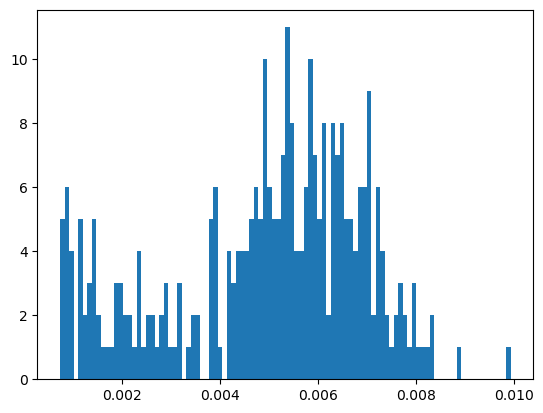

In [ ]:
fig, ax = plt.subplots()
ax.hist(distances, bins=100);

In [ ]:
fig.savefig("distances_hist.png", dpi=300)  

In [ ]:
mypoints = np.array(mypoints)
icppoints = np.array(icppoints)
pre_centers = np.array(pre_centers)

pcd_mypoints = pv.PolyData(mypoints)
pcd_icppoints = pv.PolyData(icppoints)
pcd_pre_centers = pv.PolyData(pre_centers)

pcd_mypoints["distance"] = distances
pcd_icppoints["distance"] = distances

p = pv.Plotter()

p.add_mesh(pcd_mypoints, scalars="distance", cmap="plasma", point_size=4, render_points_as_spheres=True)
#p.add_mesh(pcd_icppoints, scalars="distance", cmap="plasma", point_size=4, render_points_as_spheres=True)
#p.add_mesh(pcd_pre_centers, color="green", point_size=4, render_points_as_spheres=True)
for line in lines:
    p.add_mesh(line, color="red")


# p.add_mesh(pcd_mypoints, color="red", point_size=4, render_points_as_spheres=True)
# p.add_mesh(pcd_icppoints, color="green", point_size=4, render_points_as_spheres=True)

# for line in lines:
#     p.add_mesh(line, color="red")

pcd_all = pv.PolyData(xyz)
p.add_mesh(pcd_all, color='gray', point_size=1)
p.show()

Widget(value='<iframe src="http://localhost:41437/index.html?ui=P_0x7f1afa708040_9&reconnect=auto" class="pyvi…